<a href="https://colab.research.google.com/github/MatheusPagaime17/Analise-de-Sentimento-Reviews-Steam/blob/main/AnaliseSentimentoSteam.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. Instalação das bibliotecas Python
# Força a atualização das versões para evitar erros de compatibilidade
!pip install --upgrade transformers accelerate -q
# Instala a biblioteca para aumento de dados
!pip install nlpaug -q
print("Bibliotecas Python instaladas com sucesso!")

# 2. Download dos recursos da biblioteca NLTK
import nltk
print("\nBaixando recursos necessários do NLTK...")
# 'wordnet' e 'punkt' são para o nlpaug funcionar
nltk.download('wordnet', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)
print("Downloads do NLTK concluídos.")

# 3. Importações globais e verificação da GPU
import torch
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

# Verifica se a GPU está disponível e define o dispositivo de execução
if torch.cuda.is_available():
    device = torch.device("cuda")
    print('\nGPU está disponível! Usando a GPU:', torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print('\nGPU não disponível, usando CPU.')

Bibliotecas Python instaladas com sucesso!

Baixando recursos necessários do NLTK...
Downloads do NLTK concluídos.

GPU está disponível! Usando a GPU: Tesla T4


Arquivo CSV carregado com sucesso!
Número de reviews antes de qualquer limpeza: 9794
Número de reviews após remover nulas: 9765
Número de reviews após filtrar ruído excessivo (emojis/símbolos) e vazias: 9514

--- Distribuição das Reviews (Depois da Limpeza) ---
voted_up
True     8935
False     579
Name: count, dtype: int64

Gráfico 'distribuicao_apos_limpeza.png' salvo com sucesso.
Dataset limpo salvo em 'reviews_limpas.csv'.


/tmp/ipython-input-42167546.py:67: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='voted_up', data=df_filtered, palette=['#3498db', '#e74c3c'])


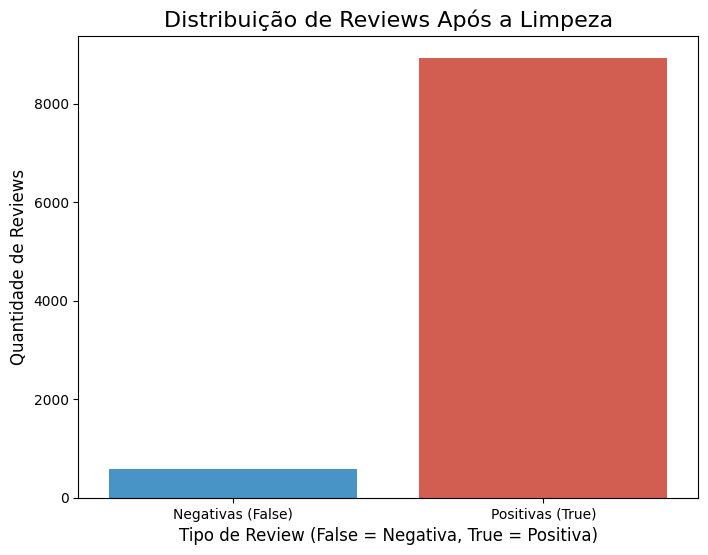

In [5]:
import re
import string

# Carregar o dataset novamente para garantir que estamos começando do ponto original
try:
    url = 'https://raw.githubusercontent.com/MatheusPagaime17/Analise-de-Sentimento-Reviews-Steam/main/elden_ring_steam_reviews.csv'
    df = pd.read_csv(url)
    print("Arquivo CSV carregado com sucesso!")
except FileNotFoundError:
    print("Erro: O arquivo 'elden_ring_steam_reviews.csv' não foi encontrado.")
    df = pd.DataFrame()

if not df.empty:
    # --- 1. Selecionar colunas relevantes e remover nulos ---
    df_clean = df[['review', 'voted_up']].copy()

    # Contagem antes de remover nulos
    print(f"Número de reviews antes de qualquer limpeza: {len(df_clean)}")

    # Remover linhas onde a review é nula
    df_clean.dropna(subset=['review'], inplace=True)
    print(f"Número de reviews após remover nulas: {len(df_clean)}")

    # --- 2. Função de limpeza de texto ---
    def clean_text(text):
        # Converter para minúsculas
        text = text.lower()
        # Remover URLs
        text = re.sub(r'https?://\S+|www\.\S+', '', text)
        # Remover pontuação
        text = text.translate(str.maketrans('', '', string.punctuation))
        # Remover números
        text = re.sub(r'\d+', '', text)
        # Remover quebras de linha e espaços extras
        text = " ".join(text.split())
        return text

    # --- 3. Função para verificar a proporção de caracteres não-alfabéticos ---
    def get_non_alpha_ratio(text):
        if not text:
            return 0
        # Conta caracteres que NÃO são letras ou espaços
        non_alpha_count = len([char for char in text if not char.isalpha() and not char.isspace()])
        return non_alpha_count / len(text)

    # Aplicar a limpeza de texto básica primeiro
    df_clean['review_cleaned'] = df_clean['review'].apply(clean_text)

    # Calcular a proporção de ruído ANTES da limpeza de texto final
    df_clean['noise_ratio'] = df_clean['review'].apply(get_non_alpha_ratio)

    # --- 4. Filtrar reviews com base na proporção de ruído e reviews vazias ---
    # Manter apenas reviews com menos de 50% de ruído
    noise_threshold = 0.5
    df_filtered = df_clean[df_clean['noise_ratio'] < noise_threshold].copy()

    # Remover reviews que se tornaram vazias após a limpeza
    df_filtered = df_filtered[df_filtered['review_cleaned'] != ''].copy()

    print(f"Número de reviews após filtrar ruído excessivo (emojis/símbolos) e vazias: {len(df_filtered)}")

    # --- 5. Visualização "Depois da Limpeza" ---
    print("\n--- Distribuição das Reviews (Depois da Limpeza) ---")
    print(df_filtered['voted_up'].value_counts())

    plt.figure(figsize=(8, 6))
    sns.countplot(x='voted_up', data=df_filtered, palette=['#3498db', '#e74c3c'])
    plt.title('Distribuição de Reviews Após a Limpeza', fontsize=16)
    plt.ylabel('Quantidade de Reviews', fontsize=12)
    plt.xlabel('Tipo de Review (False = Negativa, True = Positiva)', fontsize=12)
    plt.xticks([0, 1], ['Negativas (False)', 'Positivas (True)'])

    # Salvar o novo gráfico
    plt.savefig('distribuicao_apos_limpeza.png')
    print("\nGráfico 'distribuicao_apos_limpeza.png' salvo com sucesso.")

    # Salvar o dataframe limpo para a próxima etapa
    df_filtered[['review_cleaned', 'voted_up']].to_csv('reviews_limpas.csv', index=False)
    print("Dataset limpo salvo em 'reviews_limpas.csv'.")

In [8]:
import nlpaug.augmenter.word as naw

# Carregar o dataset limpo
try:
    df = pd.read_csv('reviews_limpas.csv')
    df.dropna(subset=['review_cleaned'], inplace=True)
    print("\nDataset limpo ('reviews_limpas.csv') carregado com sucesso.")
except FileNotFoundError:
    print("\nERRO: 'reviews_limpas.csv' não foi encontrado. Execute a célula anterior primeiro.")
    df = pd.DataFrame()

if not df.empty:
    # Separar as classes
    df_majority = df[df['voted_up'] == True]
    df_minority = df[df['voted_up'] == False]

    # Configurar o aumentador de dados
    aug = naw.SynonymAug(aug_src='wordnet', tokenizer=None, model_path=None, lang='eng', name='Synonym_Aug', stopwords=None, verbose=0)


    # Lógica de geração de dados sintéticos
    num_to_generate = len(df_majority) - len(df_minority)
    print(f"\nGerando {num_to_generate} novas reviews negativas sintéticas...")

    minority_texts = df_minority['review_cleaned'].tolist()
    augmented_texts = []

    while len(augmented_texts) < num_to_generate:
        remaining = num_to_generate - len(augmented_texts)
        batch_size = min(remaining, len(minority_texts))
        newly_augmented = aug.augment(minority_texts[:batch_size])
        augmented_texts.extend(newly_augmented)
        print(f"  Geradas {len(augmented_texts)} de {num_to_generate}...")

    print("Geração concluída!")

    # Criar DataFrame com as reviews aumentadas e combinar com o original
    df_augmented = pd.DataFrame({'review_cleaned': augmented_texts, 'voted_up': False})
    df_balanced = pd.concat([df_majority, df_minority, df_augmented], ignore_index=True)

    print("\n--- Distribuição Final das Classes Após Aumento de Dados ---")
    print(df_balanced.voted_up.value_counts())


    # Preparar dados para o modelo (divisão treino/validação)
    df_balanced['label'] = df_balanced['voted_up'].apply(lambda x: 1 if x else 0)
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        df_balanced['review_cleaned'].tolist(),
        df_balanced['label'].tolist(),
        test_size=0.2,
        random_state=42,
        stratify=df_balanced['label']
    )
    print(f"\nDados prontos para o treinamento: {len(train_texts)} amostras de treino, {len(val_texts)} amostras de validação.")


Dataset limpo ('reviews_limpas.csv') carregado com sucesso.

Gerando 8356 novas reviews negativas sintéticas...
  Geradas 579 de 8356...
  Geradas 1158 de 8356...
  Geradas 1737 de 8356...
  Geradas 2316 de 8356...
  Geradas 2895 de 8356...
  Geradas 3474 de 8356...
  Geradas 4053 de 8356...
  Geradas 4632 de 8356...
  Geradas 5211 de 8356...
  Geradas 5790 de 8356...
  Geradas 6369 de 8356...
  Geradas 6948 de 8356...
  Geradas 7527 de 8356...
  Geradas 8106 de 8356...
  Geradas 8356 de 8356...
Geração concluída!

--- Distribuição Final das Classes Após Aumento de Dados ---
voted_up
True     8935
False    8935
Name: count, dtype: int64

Dados prontos para o treinamento: 14296 amostras de treino, 3574 amostras de validação.


In [9]:
from transformers import BertTokenizer

print("Carregando o tokenizador do BERT...")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=128)

class SteamReviewDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = SteamReviewDataset(train_encodings, train_labels)
val_dataset = SteamReviewDataset(val_encodings, val_labels)

print("Tokenização completa. Datasets de treino e validação criados.")

Carregando o tokenizador do BERT...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenização completa. Datasets de treino e validação criados.


In [11]:
from transformers import BertForSequenceClassification, Trainer, TrainingArguments

# Carrega o modelo BERT pré-treinado
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device) # Mover modelo para a GPU

# Define os argumentos do treinamento
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=100,
    eval_strategy="epoch" # Corrected argument name
)

# Cria o objeto Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset
)

print("\nIniciando o treinamento do modelo...")
trainer.train()
print("Treinamento concluído!")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Iniciando o treinamento do modelo...


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: pagaime10 (pagaime10-universidade-s-o-judas-tadeu) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss
1,0.147100,0.126568


Treinamento concluído!



Avaliando o modelo no conjunto de validação...



--- Relatório de Classificação ---
              precision    recall  f1-score   support

    Negativa       0.96      0.97      0.96      1787
    Positiva       0.97      0.96      0.96      1787

    accuracy                           0.96      3574
   macro avg       0.96      0.96      0.96      3574
weighted avg       0.96      0.96      0.96      3574


--- Matriz de Confusão ---


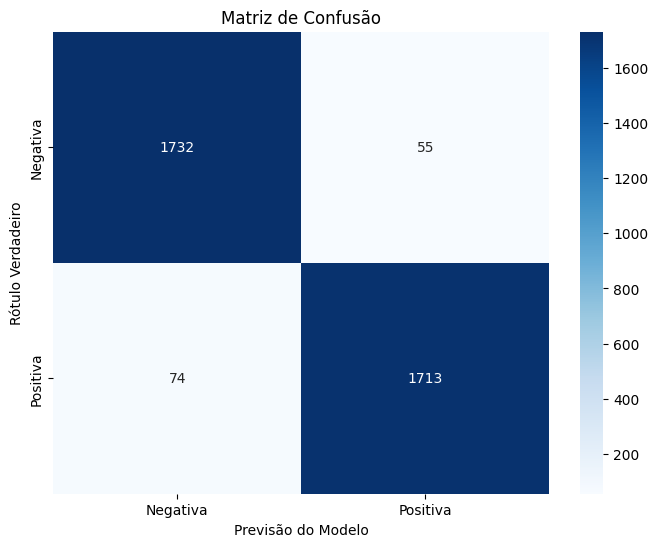

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

print("\nAvaliando o modelo no conjunto de validação...")
predictions = trainer.predict(val_dataset)
y_pred = np.argmax(predictions.predictions, axis=-1)

print("\n--- Relatório de Classificação ---")
print(classification_report(val_labels, y_pred, target_names=['Negativa', 'Positiva']))

print("\n--- Matriz de Confusão ---")
cm = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negativa', 'Positiva'],
            yticklabels=['Negativa', 'Positiva'])
plt.xlabel('Previsão do Modelo')
plt.ylabel('Rótulo Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [21]:
# Mapeamento dos rótulos
labels = ['Negativa', 'Positiva']

# Colocar o modelo em modo de avaliação
model.eval()
model.to(device)

def prever_sentimento(texto):
    """Função para prever o sentimento de um texto usando o modelo treinado."""
    # Tokenizar o texto
    inputs = tokenizer(texto, return_tensors="pt", truncation=True, padding=True, max_length=128)
    # Mover os dados para o mesmo dispositivo do modelo (GPU/CPU)
    inputs = {key: val.to(device) for key, val in inputs.items()}

    # Desativa o cálculo de gradientes para acelerar a predição
    with torch.no_grad():
        outputs = model(**inputs)

    prediction_index = torch.argmax(outputs.logits, dim=1).item()
    return labels[prediction_index]

# --- Teste a função com suas próprias frases! ---
print("\n--- Testando o modelo com frases personalizadas ---")

review_teste_1 = "One of the best experiences of my life! this game change your perception about video-games."
previsao_1 = prever_sentimento(review_teste_1)
print(f"\nTexto: '{review_teste_1}'")
print(f"Previsão do Modelo: {previsao_1}")

review_teste_2 = "Overrated! IMO the level design is mid, the game doesn't give u any advice about how you can procede or lvl up."
previsao_2 = prever_sentimento(review_teste_2)
print(f"\nTexto: '{review_teste_2}'")
print(f"Previsão do Modelo: {previsao_2}")


--- Testando o modelo com frases personalizadas ---

Texto: 'One of the best experiences of my life! this game change your perception about video-games.'
Previsão do Modelo: Positiva

Texto: 'Overrated! IMO the level design is mid, the game doesn't give u any advice about how you can procede or lvl up.'
Previsão do Modelo: Negativa
